In [ ]:
import numpy as np
import pandas as pd
from transformers import AutoModel, AutoTokenizer
from sentence_transformers import SentenceTransformer
from imblearn.over_sampling import ADASYN
import torch
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

In [2]:
model_name = "sentence-transformers/LaBSE"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [3]:
import os

print(os.listdir('./../Data/'))

['cleaned_PS_dev.csv', 'cleaned_PS_test.csv', 'cleaned_PS_train.csv', 'PS_dev.csv', 'PS_test_without_lables.csv', 'PS_train.csv', 'submission.csv']


In [ ]:
data  = pd.read_csv('./../Data/cleaned_PS_train.csv')
le = LabelEncoder()
data['label'] = le.fit_transform(data['label'])

val = pd.read_csv('./../Data/cleaned_PS_dev.csv')
val['label'] = le.transform(val['label'])

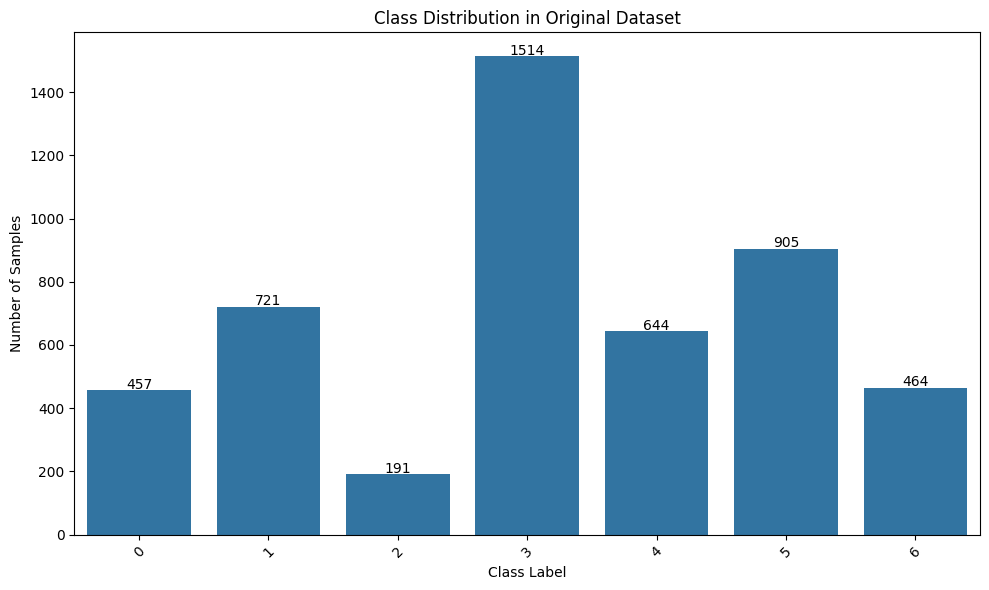

Class distribution:
Class 0: 457 samples
Class 1: 721 samples
Class 2: 191 samples
Class 3: 1514 samples
Class 4: 644 samples
Class 5: 905 samples
Class 6: 464 samples


In [3]:
import seaborn as sns

import matplotlib.pyplot as plt

# Count the occurrences of each class
class_counts = data['label'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution in Original Dataset')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)

# Add the counts as text labels above each bar
for i, count in enumerate(class_counts.values):
    plt.text(i, count + 5, str(count), ha='center')

plt.tight_layout()
plt.show()

# Print the class distribution
print("Class distribution:")
for label, count in class_counts.items():
    print(f"Class {label}: {count} samples")

In [5]:
# Display the class mapping
print("Class mapping (Original label -> Encoded integer):")
for i, class_name in enumerate(le.classes_):
    print(f"{class_name} -> {i}")

# Print the classes array
print("\nOriginal classes:")
print(le.classes_)

Class mapping (Original label -> Encoded integer):
Negative -> 0
Neutral -> 1
None of the above -> 2
Opinionated -> 3
Positive -> 4
Sarcastic -> 5
Substantiated -> 6

Original classes:
['Negative' 'Neutral' 'None of the above' 'Opinionated' 'Positive'
 'Sarcastic' 'Substantiated']


In [5]:
def get_embeddings(sentences):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Detect available device
    model.to(device)  # Move model to correct device

    embeddings = []
    for sentence in tqdm(sentences, desc="Extracting Embeddings"):
        inputs = tokenizer(sentence, padding=True, truncation=True, return_tensors="pt")
        inputs = {key: value.to(device) for key, value in inputs.items()}  # Move inputs to GPU if available

        with torch.no_grad():
            outputs = model(**inputs)

        embeddings.append(outputs.pooler_output.squeeze(0).cpu().numpy())  # Move tensor back to CPU for NumPy
    return np.array(embeddings)


In [6]:
X_embeddings = get_embeddings(data["content"].tolist())
y = data["label"].values

Extracting Embeddings: 100%|██████████| 4352/4352 [01:05<00:00, 66.39it/s]


In [7]:
X_test  = get_embeddings(val["content"].tolist())

Extracting Embeddings: 100%|██████████| 544/544 [00:11<00:00, 46.20it/s]


In [ ]:
adasyn = ADASYN(sampling_strategy='all', random_state=42, n_neighbors=7)
X_resampled, y_resampled = adasyn.fit_resample(X_embeddings, y)

print("Original class distribution:", {label: sum(y == label) for label in np.unique(y)})
print("Resampled class distribution:", {label: sum(y_resampled == label) for label in np.unique(y_resampled)})

Original class distribution: {0: 406, 1: 637, 2: 171, 3: 1361, 4: 575, 5: 790, 6: 412}
Resampled class distribution: {0: 1409, 1: 1266, 2: 1370, 3: 1361, 4: 1391, 5: 1398, 6: 1459}


In [31]:
X_train, X_test, y_train, y_test = X_resampled, X_test, y_resampled, val["label"].values

In [32]:
type(X_train), type(y_train), type(X_test), type(y_test)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [33]:
print("\nTraining SVM...")
svm_clf = SVC(kernel='linear', probability=True)
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)

print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))



Training SVM...

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.13      0.25      0.17        51
           1       0.15      0.15      0.15        84
           2       0.79      0.75      0.77        20
           3       0.36      0.24      0.28       153
           4       0.24      0.29      0.26        69
           5       0.46      0.38      0.42       115
           6       0.10      0.12      0.11        52

    accuracy                           0.27       544
   macro avg       0.32      0.31      0.31       544
weighted avg       0.30      0.27      0.28       544

SVM Accuracy: 0.2702205882352941


In [34]:
print("\nTraining XGBoost...")
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)

print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))


Training XGBoost...


c:\Users\nithi\anaconda3\envs\College\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:51:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.10      0.12        51
           1       0.27      0.18      0.21        84
           2       0.80      0.80      0.80        20
           3       0.34      0.46      0.39       153
           4       0.20      0.19      0.19        69
           5       0.40      0.43      0.41       115
           6       0.16      0.12      0.13        52

    accuracy                           0.32       544
   macro avg       0.33      0.32      0.32       544
weighted avg       0.31      0.32      0.31       544

XGBoost Accuracy: 0.32169117647058826


In [25]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

input_dim = X_train.shape[1]
num_classes = len(set(y))  # Number of unique labels
lr = 0.001
epochs = 30
batch_size = 32

print(num_classes,input_dim)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


7 768


In [26]:
class ComplexMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ComplexMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.2)

        self.fc4 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        return x


In [27]:
mlp_model = ComplexMLP(input_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=lr)

# Train MLP
print("\nTraining Deep Learning Model...")
mlp_model.train()
for epoch in range(epochs):
    for batch_X, batch_y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        optimizer.zero_grad()
        outputs = mlp_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

# Evaluate MLP
mlp_model.eval()
with torch.no_grad():
    outputs = mlp_model(X_test_tensor)
    y_pred_mlp = torch.argmax(outputs, axis=1).cpu().numpy()

print("\nMLP Classification Report:")
print(classification_report(y_test, y_pred_mlp))
print("MLP Accuracy:", accuracy_score(y_test, y_pred_mlp))



Training Deep Learning Model...


Epoch 30/30: 100%|██████████| 174/174 [00:00<00:00, 245.33it/s]


MLP Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.18      0.17        51
           1       0.15      0.12      0.13        84
           2       0.82      0.90      0.86        20
           3       0.33      0.44      0.38       153
           4       0.25      0.22      0.23        69
           5       0.39      0.36      0.37       115
           6       0.16      0.12      0.13        52

    accuracy                           0.31       544
   macro avg       0.33      0.33      0.33       544
weighted avg       0.29      0.31      0.30       544

MLP Accuracy: 0.30514705882352944


In [28]:
print("\nTraining Decision Tree...")
decisiontree = DecisionTreeClassifier()
decisiontree.fit(X_train, y_train)
y_pred_dct = decisiontree.predict(X_test)

print("\Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))

<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\D'
C:\Users\nithi\AppData\Local\Temp\ipykernel_31692\523938766.py:6: SyntaxWarning: invalid escape sequence '\D'
  print("\Decision Tree Classification Report:")



Training Decision Tree...
\Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.06      0.10        51
           1       0.29      0.14      0.19        84
           2       0.82      0.90      0.86        20
           3       0.34      0.65      0.44       153
           4       0.22      0.14      0.17        69
           5       0.39      0.37      0.38       115
           6       0.19      0.06      0.09        52

    accuracy                           0.35       544
   macro avg       0.36      0.33      0.32       544
weighted avg       0.32      0.35      0.30       544

XGBoost Accuracy: 0.34558823529411764


In [29]:
print("\nTraining Random Forest...")
randomforest = RandomForestClassifier()
randomforest.fit(X_train, y_train)
y_pred_rft = randomforest.predict(X_test)

print("\Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rft))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rft))

<>:6: SyntaxWarning: invalid escape sequence '\R'
<>:6: SyntaxWarning: invalid escape sequence '\R'
C:\Users\nithi\AppData\Local\Temp\ipykernel_31692\1871881546.py:6: SyntaxWarning: invalid escape sequence '\R'
  print("\Random Forest Classification Report:")



Training Random Forest...
\Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.06      0.10        51
           1       0.22      0.07      0.11        84
           2       0.82      0.90      0.86        20
           3       0.31      0.76      0.44       153
           4       0.27      0.09      0.13        69
           5       0.36      0.23      0.28       115
           6       0.15      0.04      0.06        52

    accuracy                           0.33       544
   macro avg       0.37      0.31      0.28       544
weighted avg       0.32      0.33      0.26       544

Random Forest Accuracy: 0.3272058823529412
